# IMPORTING LIBRARIES


In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


In [2]:
#!pip install scikit-learn

# INPUT


In [69]:
# Define file paths or names
#df_ode_results = pd.read_excel('data.xlsx')
df_ode_results = pd.read_excel('../data/groundtruth_compartments.xlsx')

#data from 2012-2018
daily_data_compartments = df_ode_results
start_date = '2012-01-01 00:00:00'
#start_date = '2010-01-01 00:00:00'
end_date = '2018-12-31 00:00:00'
# Filter rows for a date range (e.g., from '2012-01-01' to '2018-12-31')
data = daily_data_compartments[(daily_data_compartments['Date'] >= start_date) & (daily_data_compartments['Date'] <= end_date)]

start_Day = 0
end_Day = 2531
data = data.loc[start_Day:end_Day]

# Check if start_date exists in the 'Date' column
if start_date in data['Date'].values:
    sh_value_at_start = data['Sh'][data['Date'] == start_date].values[0]
    print("Sh value at start date:", sh_value_at_start)
else:
    print(f"Date '{start_date}' not found in the data.")

print(data.columns)
#this just to check the total human population is constant or not
print(data['Sh'][start_Day]+data['Ih'][start_Day]+data['Rh'][start_Day])
days = 1000
print(data['Sh'][days+start_Day]+data['Ih'][days+start_Day]+data['Rh'][days+start_Day])


Date '2012-01-01 00:00:00' not found in the data.
Index(['Date', 'Sh', 'Ih', 'Rh', 'Sa', 'Ia', 'Ra', 'L', 'Ch',
       'daily_cases_array', 'my_daily_new_infections'],
      dtype='object')
2420465.0
2420465.0000000075


In [70]:
#Aj Ih
df_ode_results_previous_work = pd.read_excel('../data/data.xlsx')
data_previous_work = df_ode_results_previous_work[(df_ode_results_previous_work['Date'] >= start_date) & (df_ode_results_previous_work['Date'] <= end_date)]

start_Day = 0
end_Day = 2531
data_previous_work = data_previous_work.loc[start_Day:end_Day]
data_previous_work.columns

Index(['Day', 'Sh', 'Ih', 'Rh', 'Sa', 'Ia', 'Ra', 'L', 'Ch', 'Date'], dtype='object')

In [71]:
#start_Day = 730

Nh = data['Sh'][start_Day]+data['Ih'][start_Day]+data['Rh'][start_Day]
Na = data['Sa'][start_Day]+data['Ia'][start_Day]+data['Ra'][start_Day]

In [72]:

# Initial conditions
#Sh0 = data["Sh"][start_Day]
Sh0 = data["Sh"][start_Day]
#Ih0 = data["Ih"][start_Day]
Ih0 = data["Ih"][start_Day]
#Rh0 = data["Rh"][start_Day]
Rh0 = data["Rh"][start_Day]
Sa0 = data["Sa"][start_Day]
Ia0 = data["Ia"][start_Day]
Ra0 = data["Ra"][start_Day]
L0 = data["L"][start_Day]
Ch0 = data["Ch"][start_Day]
initial_conditions = [Sh0, Ih0, Rh0, Sa0, Ia0, Ra0, L0, Ch0]

In [74]:
#flood
df_covariates = pd.read_excel('../data/covariates_date.xlsx')

data_covariates = df_covariates[(df_covariates['Date'] >= start_date) & (df_covariates['Date'] <= end_date)]
# Print the result
#print(data_covariates)
data_covariates = data_covariates.loc[start_Day:end_Day]
print(df_covariates.columns)
df_covariates["betaHL"].values

Index(['Day', 'WaterIndex', 'Temperature', 'betaHL', 'betaAL', 'Date', 'Rain'], dtype='object')


array([1.72976821, 1.72566048, 1.72070171, ..., 1.88994283, 1.8366545 ,
       1.78336618])

In [75]:

def prepare_lstm_input_output(df1, df2, columns_df1, columns_df2, target_columns, sequence_length=7):
    """
    Prepares LSTM input data from two DataFrames and output (targets) from another DataFrame using a sequence length.
    
    Parameters:
    df1 (pd.DataFrame): The first DataFrame containing some covariates (e.g., 'Ih' or 'Ia').
    df2 (pd.DataFrame): The second DataFrame containing other covariates (e.g., 'Rain').
    columns_df1 (list): A list of column names to select from df1 (e.g., ['Ih'] or ['Ia']).
    columns_df2 (list): A list of column names to select from df2 (e.g., ['Rain']).
    target_columns (list): A list of target column names (e.g., ['Sh', 'Ih', 'Rh', ...]).
    sequence_length (int): The length of the input sequence (default is 7).
    
    Returns:
    X (np.array): A 3D NumPy array with shape (number_of_samples, sequence_length, number_of_features) for inputs.
    y (np.array): A 2D NumPy array with shape (number_of_samples, number_of_targets) for outputs.
    """
    
    # Step 1: Extract selected columns from both DataFrames for inputs
    data_df1 = df1[columns_df1].values
    data_df2 = df2[columns_df2].values
    
    # Step 2: Concatenate the selected columns along axis 1 (combine features)
    combined_data = np.concatenate((data_df1, data_df2), axis=1)
    
    # Step 3: Prepare the sliding windows (input sequences for the LSTM)
    X = []
    for i in range(len(combined_data) - sequence_length):
        # Create a sliding window of size `sequence_length`
        X.append(combined_data[i:i + sequence_length])

    # Step 4: Convert X to a NumPy array (inputs)
    X = np.array(X)
    
    # Step 5: Extract target columns from the same DataFrame (for outputs)
    targets = df1[target_columns].values
    
    # Step 6: Prepare the outputs by aligning with the input sliding windows
    y = targets[sequence_length:]
    
    # Step 7: Return both the inputs (X) and outputs (y)
    return X, y


# For human: Combining 'Ih' and 'WaterIndex'
#columns_df1 = ['Ih']  # From the first DataFrame (human)
columns_df1 = ["Ih"]
columns_df2 = ['WaterIndex', 'Temperature']# From the second DataFrame (flooding data, temperature data)
sequence_length = 1
# Target columns for human output, animal output and contaminated environment
#target_columns = ['Sh', "Transformed_Ih", 'Rh', 'Sa', 'Ia', 'Ra', 'L', 'Ch'] 
target_columns = ['Sh', "Ih", 'Rh', 'Sa', 'Ia', 'Ra', 'L', 'Ch'] 
# Prepare LSTM input and output for humans
X_human, y = prepare_lstm_input_output(data, data_covariates, columns_df1, columns_df2, target_columns, sequence_length)
# Print the shape of the LSTM input and output
print("Shape of X_human (Human inputs):", X_human.shape)  # (number_of_samples, sequence_length, number_of_features)
print("Shape of y (all outputs):", y.shape)  # (number_of_samples, number_of_targets)


# For animal: Combining 'Ia' and 'WaterIndex'
columns_df3 = ['Ia']  # From the first DataFrame (animal)
# Prepare LSTM input and output for animals
X_animal, _ = prepare_lstm_input_output(data, data_covariates, columns_df3, columns_df2, target_columns, sequence_length)
# Print the shape of the LSTM input and output for animals
print("Shape of X_animal (Animal inputs):", X_animal.shape)  # (number_of_samples, sequence_length, number_of_features)


Shape of X_human (Human inputs): (2531, 1, 3)
Shape of y (all outputs): (2531, 8)
Shape of X_animal (Animal inputs): (2531, 1, 3)


In [76]:

# Convert X_human to a tensor
combined_features_Ih = torch.tensor(X_human, dtype=torch.float32)

# Convert X_animal to a tensor
combined_features_Ia = torch.tensor(X_animal, dtype=torch.float32)

# Print the shapes to verify
print("X_human_tensor shape:", combined_features_Ih.shape)  # (num_samples, sequence_length, num_features)
print("X_animal_tensor shape:", combined_features_Ia.shape)  # (num_samples, sequence_length, num_features)


X_human_tensor shape: torch.Size([2531, 1, 3])
X_animal_tensor shape: torch.Size([2531, 1, 3])


In [77]:

# Training size (same for human and animal)
train_size = 2191

# Split human data into train and test sets
X_human_train = combined_features_Ih[:train_size]
X_human_test = combined_features_Ih[train_size:]


In [78]:
# `y` has the shape (num_samples, 8)
# `y` represents the outputs: [Sh, Ih, Rh, Sa, Ia, Ra, L, Ch]

# Split the `y` array into individual outputs
Sh, Ih, Rh, Sa, Ia, Ra, L, Ch = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4], y[:, 5], y[:, 6], y[:, 7]

# Convert each to a torch tensor and reshape to (num_samples, 1)
Sh_z = torch.tensor(Sh, dtype=torch.float32).reshape(-1, 1)
Ih_z = torch.tensor(Ih, dtype=torch.float32).reshape(-1, 1)
Rh_z = torch.tensor(Rh, dtype=torch.float32).reshape(-1, 1)
Sa_z = torch.tensor(Sa, dtype=torch.float32).reshape(-1, 1)
Ia_z = torch.tensor(Ia, dtype=torch.float32).reshape(-1, 1)
Ra_z = torch.tensor(Ra, dtype=torch.float32).reshape(-1, 1)
L_z = torch.tensor(L, dtype=torch.float32).reshape(-1, 1)
Ch_z = torch.tensor(Ch, dtype=torch.float32).reshape(-1, 1)

# Print the shapes of the tensors to verify
print("Sh_z shape:", Sh_z.shape)
print("Ih_z shape:", Ih_z.shape)
print("Rh_z shape:", Rh_z.shape)
print("Sa_z shape:", Sa_z.shape)
print("Ia_z shape:", Ia_z.shape)
print("Ra_z shape:", Ra_z.shape)
print("L_z shape:", L_z.shape)
print("Ch_z shape:", Ch_z.shape)


Sh_z shape: torch.Size([2531, 1])
Ih_z shape: torch.Size([2531, 1])
Rh_z shape: torch.Size([2531, 1])
Sa_z shape: torch.Size([2531, 1])
Ia_z shape: torch.Size([2531, 1])
Ra_z shape: torch.Size([2531, 1])
L_z shape: torch.Size([2531, 1])
Ch_z shape: torch.Size([2531, 1])


In [79]:

Sh_z_train = Sh_z[:train_size]
Sh_z_test  = Sh_z[train_size:]

Ih_z_train = Ih_z[:train_size]
Ih_z_test  = Ih_z[train_size:]

Rh_z_train = Rh_z[:train_size]
Rh_z_test  = Rh_z[train_size:]

Sa_z_train = Sa_z[:train_size]
Sa_z_test  = Sa_z[train_size:]

Ia_z_train = Ia_z[:train_size]
Ia_z_test  = Ia_z[train_size:]

Ra_z_train = Ra_z[:train_size]
Ra_z_test  = Ra_z[train_size:]

L_z_train  = L_z[:train_size]
L_z_test   = L_z[train_size:]

Ch_z_train = Ch_z[:train_size]
Ch_z_test  = Ch_z[train_size:]


# NEURAL NETWORK MODEL


In [80]:
#input_size = 3 #use 3 features ie water index, temperature, and cases

import torch
import torch.nn as nn

class LSTMParameterModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMParameterModel, self).__init__()

        # LSTM layer to capture temporal dependencies
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layers to capture nonlinear relationships
        self.fc1 = nn.Linear(hidden_size, 50)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc4 = nn.Linear(30, output_size)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # Assuming you want sigmoid for final output to constrain it between [0,1]

    def forward(self, x):
        # Pass input through LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)

        # Take the last time step (if dealing with sequence data)
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Pass through fully connected layers
        x = self.relu(self.fc1(lstm_out))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Assuming the output needs to be constrained in [0, 1]

        return x


# RUNGE KUTTA METHOD FOR SOLVING ODEs


In [81]:

#"C:/Users/Sumet Kh/Downloads/PhD/Sumet/inputCodeV17.csv"

# Define file paths or names
inputCodeV17_path = "../data/inputCodeV17.csv"
DataInfect_path = "../data/DataInfectBiWeekly2010to2018_2P.csv"
PercentMNDWI_path = "../data/PercentMNDWI2009to2018_norm_2P.csv"
AveTemp_path = "../data/AveTemp2009to2018Sp_norm_2P.csv"
Rainfall_path = "../data/Rainfall2009to2018_norm_2P.csv"
summaryV19_plot_path = '../data/summaryV19_plot.xlsx'

# Reading CSV Files
inputData = pd.read_csv(inputCodeV17_path)
DataInfect = pd.read_csv(DataInfect_path)
MNDWI = pd.read_csv(PercentMNDWI_path)
Temp = pd.read_csv(AveTemp_path)
Rain = pd.read_csv(Rainfall_path)

# Reading Excel Files (reading a specific sheet)
inputparm = pd.read_excel(summaryV19_plot_path, sheet_name=7)  # Assumed sheet index as 7, adjust as needed

muH=1.0/(70*365); gammaH=1.0/14; nuH=1.0/720
muA=1.0/(3*365); gammaA=1.0/200; nuA=1.0/540
muL=0.02381;  chi=1e5

params = inputparm.loc[7, ['BetaHA', 'BetaAA', 'meanBetaHL', 'meanBetaAL', 'omega', 'm', 't1', 't2', 'K']].tolist() #SisaketSurin
params.extend([Nh, Na])
betaHA, betaAA, _, betaAL, omega, m, t1, t2, K, Nh, Na = params


In [82]:

# Model using the fourth-order Runge-Kutta method for the simplified input set
def new_model_rk4(Sh, Ih, Rh, Sa, Ia, Ra, L, Ch, betaHL, betaAL, dt=1):
    def derivatives(Sh, Ih, Rh, Sa, Ia, Ra, L, Ch, betaHL, betaAL):
        # ODE equations
        dSh = muH*Nh-betaHA * Ia * Sh / Nh - betaHL * (L / (L + K)) * Sh / Nh  - muH*Sh + nuH*Rh
        dIh = betaHA * Ia * Sh / Nh + betaHL * (L / (L + K)) * Sh / Nh - gammaH*Ih - muH*Ih
        dRh = gammaH*Ih - muH*Rh - nuH*Rh
        dSa = muA*Na-betaAA*Ia*Sa/Na - betaAL*(L/(L+K))*Sa/Na  - muA*Sa + nuA*Ra #sa
        dIa = betaAA * Ia * Sa / Na + betaAL * (L / (L + K)) * Sa / Na - gammaA*Ia - muA*Ia
        dRa = gammaA*Ia - nuA*Ra - muA*Ra
        dL = omega * Ia + m * ((chi - L) / chi) * L - muL * L
        dCh = betaHA * Ia * Sh / Nh + betaHL * (L / (L + K)) * Sh / Nh
        
        return dSh, dIh, dRh, dSa, dIa, dRa, dL, dCh

    # First step of RK4
    K1_Sh, K1_Ih, K1_Rh, K1_Sa, K1_Ia, K1_Ra, K1_L, K1_Ch = derivatives(Sh, Ih, Rh, Sa, Ia, Ra, L, Ch, betaHL, betaAL)

    # Second step of RK4
    K2_Sh, K2_Ih, K2_Rh, K2_Sa, K2_Ia, K2_Ra, K2_L, K2_Ch = derivatives(
        Sh + 0.5 * dt * K1_Sh, Ih + 0.5 * dt * K1_Ih, Rh + 0.5 * dt * K1_Rh, 
        Sa + 0.5 * dt * K1_Sa, Ia + 0.5 * dt * K1_Ia, Ra + 0.5 * dt * K1_Ra, 
        L + 0.5 * dt * K1_L, Ch + 0.5 * dt * K1_Ch, betaHL, betaAL)

    # Third step of RK4
    K3_Sh, K3_Ih, K3_Rh, K3_Sa, K3_Ia, K3_Ra, K3_L, K3_Ch = derivatives(
        Sh + 0.5 * dt * K2_Sh, Ih + 0.5 * dt * K2_Ih, Rh + 0.5 * dt * K2_Rh, 
        Sa + 0.5 * dt * K2_Sa, Ia + 0.5 * dt * K2_Ia, Ra + 0.5 * dt * K2_Ra, 
        L + 0.5 * dt * K2_L, Ch + 0.5 * dt * K2_Ch, betaHL, betaAL)

    # Fourth step of RK4
    K4_Sh, K4_Ih, K4_Rh, K4_Sa, K4_Ia, K4_Ra, K4_L, K4_Ch = derivatives(
        Sh + dt * K3_Sh, Ih + dt * K3_Ih, Rh + dt * K3_Rh, 
        Sa + dt * K3_Sa, Ia + dt * K3_Ia, Ra + dt * K3_Ra, 
        L + dt * K3_L, Ch + dt * K3_Ch, betaHL, betaAL)

    # Update next step using RK4 formula
    Sh_next = Sh + (dt / 6) * (K1_Sh + 2 * K2_Sh + 2 * K3_Sh + K4_Sh)
    Ih_next = Ih + (dt / 6) * (K1_Ih + 2 * K2_Ih + 2 * K3_Ih + K4_Ih)
    Rh_next = Rh + (dt / 6) * (K1_Rh + 2 * K2_Rh + 2 * K3_Rh + K4_Rh)
    Sa_next = Sa + (dt / 6) * (K1_Sa + 2 * K2_Sa + 2 * K3_Sa + K4_Sa)
    Ia_next = Ia + (dt / 6) * (K1_Ia + 2 * K2_Ia + 2 * K3_Ia + K4_Ia)
    Ra_next = Ra + (dt / 6) * (K1_Ra + 2 * K2_Ra + 2 * K3_Ra + K4_Ra)
    L_next = L + (dt / 6) * (K1_L + 2 * K2_L + 2 * K3_L + K4_L)
    Ch_next = Ch + (dt / 6) * (K1_Ch + 2 * K2_Ch + 2 * K3_Ch + K4_Ch)

    return Sh_next, Ih_next, Rh_next, Sa_next, Ia_next, Ra_next, L_next, Ch_next


# LOSS FUNCTION


In [83]:
# Loss function for the new model
def lstm_loss_function(Sh_true, Ih_true, Rh_true, Sa_true, Ia_true, Ra_true, L_true, Ch_true, 
                  Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred,
                  omega_Sh, omega_Ih, omega_Rh, omega_Sa, omega_Ia, omega_Ra, omega_L, omega_Ch, omega_params):
    
    # Compute the loss for each variable (mean squared error)
    loss_Sh = torch.mean((Sh_true - Sh_pred) ** 2) * omega_Sh
    loss_Ih = torch.mean((Ih_true - Ih_pred) ** 2) * omega_Ih
    loss_Rh = torch.mean((Rh_true - Rh_pred) ** 2) * omega_Rh
    loss_Sa = torch.mean((Sa_true - Sa_pred) ** 2) * omega_Sa
    loss_Ia = torch.mean((Ia_true - Ia_pred) ** 2) * omega_Ia
    loss_Ra = torch.mean((Ra_true - Ra_pred) ** 2) * omega_Ra
    loss_L = torch.mean((L_true - L_pred) ** 2) * omega_L
    loss_Ch = torch.mean((Ch_true - Ch_pred) ** 2) * omega_Ch
    
    # Add regularization loss (optional, for controlling model complexity)
    # Regularization loss to control model complexity
    regularization_loss = omega_params * (
        torch.sum(betaHL_model.lstm.weight_hh_l0**2) +  # Regularize LSTM recurrent weights
        torch.sum(betaHL_model.lstm.weight_ih_l0**2) +  # Regularize LSTM input weights
        torch.sum(betaHL_model.fc1.weight**2) +  # Regularize FC layers
        torch.sum(betaHL_model.fc2.weight**2) +
        torch.sum(betaHL_model.fc3.weight**2) 
    )

    # Total loss as the sum of all individual losses
    total_loss = loss_Sh + loss_Ih + loss_Rh + loss_Sa + loss_Ia + loss_Ra + loss_L + loss_Ch + regularization_loss
    #total_loss = loss_Ih
    
    return total_loss


# TRAINING THE MODEL

In [84]:
# Training the new model
def train_new_model_features(max_epoch, features_h, features_a, Sh_data, Ih_data, Rh_data, Sa_data, Ia_data, Ra_data, L_data, Ch_data, 
                    betaHL_model, omega_Sh, omega_Ih, omega_Rh, omega_Sa, omega_Ia, omega_Ra, omega_L, omega_Ch, omega_params):
    
    optimizer = optim.Adam(list(betaHL_model.parameters()), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)

    total_loss_values = []
    log_loss_values = []
    betaHL = []

    for epoch in range(max_epoch):
        optimizer.zero_grad()

        # Predict betaHL using the models
        betaHL = betaHL_model(features_h)

        # Use RK4 to predict the next state variables
        Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred = new_model_rk4(
            Sh_data, Ih_data, Rh_data, Sa_data, Ia_data, Ra_data, L_data, Ch_data, betaHL, betaAL)

        # Compute the loss
        loss = lstm_loss_function(Sh_data, Ih_data, Rh_data, Sa_data, Ia_data, Ra_data, L_data, Ch_data, 
                             Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred,
                             omega_Sh, omega_Ih, omega_Rh, omega_Sa, omega_Ia, omega_Ra, omega_L, omega_Ch, omega_params)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Log the loss values
        total_loss_values.append(loss.item())
        log_loss_values.append(torch.log(loss).item())

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return total_loss_values, log_loss_values, betaHL


In [85]:
# Hyperparameters
max_epoch = 250
# Change according to compartment weightage
omega_Sh = 1.0
omega_Ih = 1.0
omega_Rh = 1.0
omega_Sa = 1.0
omega_Ia = 1.0
omega_Ra = 1.0
omega_L = 1.0
omega_Ch = 1.0
omega_params = 0.05 #omega_params = 0.0005

# Initialize models
betaHL_model = LSTMParameterModel() #lstm neural network

# Now call the modified training function for the new model structure
total_loss_values, log_loss_values, outputs_betaHL_train = train_new_model_features(
    max_epoch, 
    features_h=X_human_train,
    features_a=combined_features_Ia,
    Sh_data=Sh_z_train, Ih_data=Ih_z_train, Rh_data=Rh_z_train, 
    Sa_data=Sa_z_train, Ia_data=Ia_z_train, Ra_data=Ra_z_train, 
    L_data=L_z_train, Ch_data=Ch_z_train,  
    betaHL_model=betaHL_model, 
    omega_Sh=omega_Sh, omega_Ih=omega_Ih, omega_Rh=omega_Rh, 
    omega_Sa=omega_Sa, omega_Ia=omega_Ia, omega_Ra=omega_Ra, 
    omega_L=omega_L, omega_Ch=omega_Ch, 
    omega_params=omega_params
)



Epoch 0, Loss: 31.96148681640625
Epoch 10, Loss: 30.613588333129883
Epoch 20, Loss: 29.49950408935547
Epoch 30, Loss: 28.6030330657959
Epoch 40, Loss: 27.893775939941406
Epoch 50, Loss: 27.339902877807617
Epoch 60, Loss: 26.911521911621094
Epoch 70, Loss: 26.58209228515625
Epoch 80, Loss: 26.3308048248291
Epoch 90, Loss: 26.139902114868164
Epoch 100, Loss: 25.995689392089844
Epoch 110, Loss: 25.88294219970703
Epoch 120, Loss: 25.795976638793945
Epoch 130, Loss: 25.730445861816406
Epoch 140, Loss: 25.681400299072266
Epoch 150, Loss: 25.64411163330078
Epoch 160, Loss: 25.605091094970703
Epoch 170, Loss: 25.576528549194336
Epoch 180, Loss: 25.546903610229492
Epoch 190, Loss: 25.52951431274414
Epoch 200, Loss: 25.520296096801758
Epoch 210, Loss: 25.5120792388916
Epoch 220, Loss: 25.50339126586914
Epoch 230, Loss: 25.496458053588867
Epoch 240, Loss: 25.49003028869629


In [86]:
betaHL_list = df_covariates["betaHL"][start_Day:end_Day].values
# Convert outputs_betaHL and outputs_betaAL from tensor to numpy for plotting
outputs_betaHL_train_np = outputs_betaHL_train.detach().numpy().flatten()  # Flatten to 1D for comparison

# Ensure outputs_betaHL and outputs_betaAL are scaled to match the range of true_betaHL and true_betaAL
outputs_betaHL_train_scaled = (outputs_betaHL_train_np - outputs_betaHL_train_np.min()) / (outputs_betaHL_train_np.max() - outputs_betaHL_train_np.min())
outputs_betaHL_train_scaled = outputs_betaHL_train_scaled * (betaHL_list.max() - betaHL_list.min()) + betaHL_list.min()

Loss values saved as 'loss_values_1stmodel_floodTEMPcases_seqlen1.csv'.


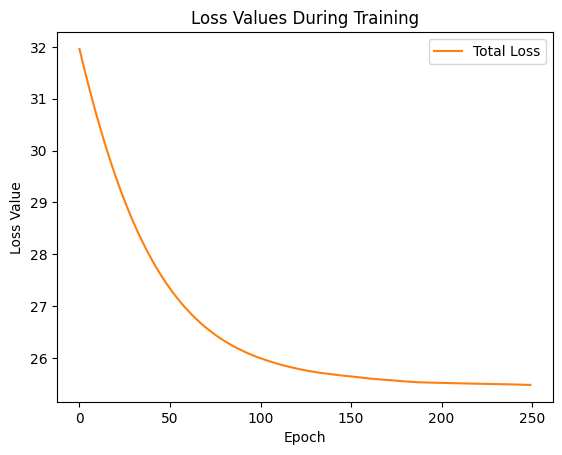

In [87]:
# Create a DataFrame with both lists as columns
df_loss_1stmodel = pd.DataFrame({
    'Total_Loss_Values': total_loss_values,
    'Log_Loss_Values': log_loss_values
})

# Save the DataFrame as a CSV file
#df_loss_1stmodel.to_csv('../results/loss_values_1stmodel_floodTEMPcases_seqlen1.csv', index=False)

print("Loss values saved as 'loss_values_1stmodel_floodTEMPcases_seqlen1.csv'.")
# Plot Total Loss Values
plt.plot(df_loss_1stmodel['Total_Loss_Values'], label='Total Loss', color='#ff7f0e') #color='#a0b9e0'

# Plot Log Loss Values
#plt.plot(df_loss_1stmodel['Log_Loss_Values'], label='Log Loss', color='orange')

# Labeling the plot
plt.title("Loss Values During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.legend()

# Save the plot as a PNG file
#plt.savefig("../results/training_loss_plot_1stmodel_floodTEMPcases_seqlen1.png", dpi=300)  # Save with high resolution

# Show the plot
plt.show()

In [21]:

#torch.save(betaHL_model.state_dict(), 'PE_lstm_hybrid_model_floodTEMPcases.pth')


In [89]:
#load the trained model
betaHL_model = LSTMParameterModel(input_size=3, hidden_size=64, num_layers=2, output_size=1)
# Load the previously saved weights
betaHL_model.load_state_dict(torch.load('../results/PE_lstm_hybrid_model_floodTEMPcases.pth'))
# Ensure the model is in evaluation mode
betaHL_model.eval()

C:\Users\Sumet Kh\AppData\Local\Temp\ipykernel_33708\2012900380.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  betaHL_model.load_state_dict(torch.load('../results/PE_ls

LSTMParameterModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [90]:
def predict_new_model(features_h, features_a, Sh, Ih, Rh, Sa, Ia, Ra, L, Ch, betaHL_model):
    betaHL = betaHL_model(features_h).squeeze()  # Shape becomes (1000,)
    betaHL = betaHL.unsqueeze(1)
    print(betaHL.shape)
    print(Sh.shape)

    # Use the Runge-Kutta method to predict the next state variables
    Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred = new_model_rk4(
        Sh, Ih, Rh, Sa, Ia, Ra, L, Ch, betaHL, betaAL)

    return Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred

# Predicting using the new function
Sh_pred, Ih_pred, Rh_pred, Sa_pred, Ia_pred, Ra_pred, L_pred, Ch_pred= predict_new_model(
    features_h=X_human_train,
    features_a=combined_features_Ia,
    Sh=Sh_z_train, Ih=Ih_z_train, Rh=Rh_z_train, 
    Sa=Sa_z_train, Ia=Ia_z_train, Ra=Ra_z_train, 
    L=L_z_train, Ch=Ch_z_train, 
    betaHL_model=betaHL_model)

# Converting predicted values from tensors to numpy arrays
Sh_pred = Sh_pred.detach().numpy()
Ih_pred = Ih_pred.detach().numpy()
Rh_pred = Rh_pred.detach().numpy()
Sa_pred = Sa_pred.detach().numpy()
Ia_pred = Ia_pred.detach().numpy()
Ra_pred = Ra_pred.detach().numpy()
L_pred = L_pred.detach().numpy()
Ch_pred = Ch_pred.detach().numpy()

torch.Size([2191, 1])
torch.Size([2191, 1])


In [91]:
# Print total number of parameters
total_params = sum(p.numel() for p in betaHL_model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 56685


# PLOTTING ACTUAL- VS PREDICTED- VALUES OF Sh,Ih,Rh,Sa,Ia,Ra,L

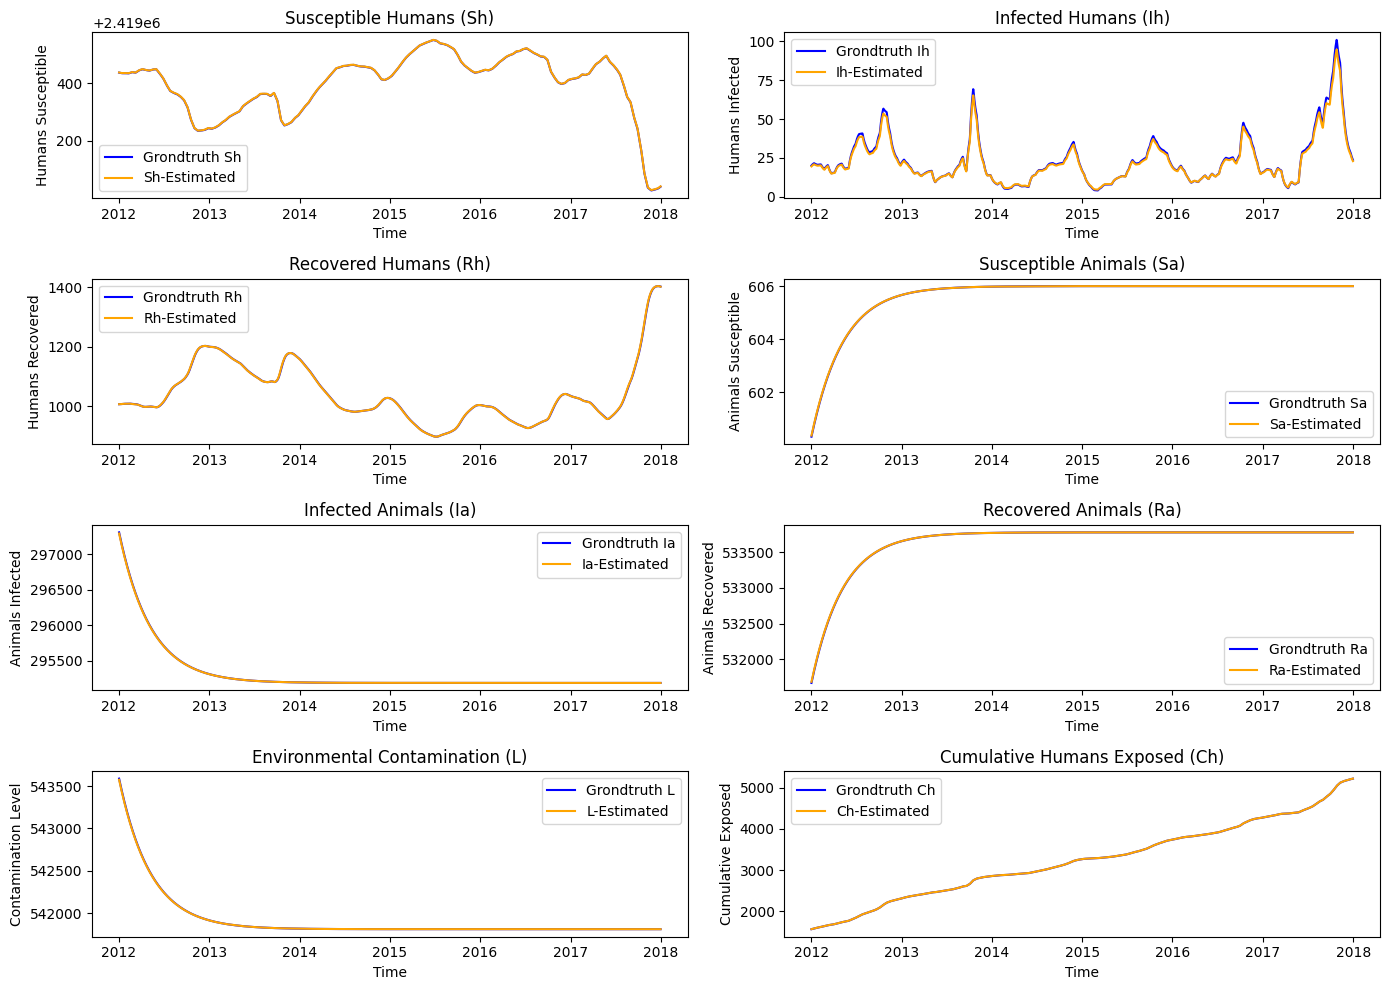

In [92]:
#use real data (latest)
# Plotting the actual vs predicted values for 8 compartments
plt.figure(figsize=(14, 10))

# Plot for Sh (Human Susceptible)
plt.subplot(4, 2, 1)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sh[:train_size], label='Grondtruth Sh', color='blue')#color='#a0b9e0')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sh_pred, label='Sh-Estimated', color='orange')#color='#eba58d')
plt.title('Susceptible Humans (Sh)')
plt.xlabel('Time')
plt.ylabel('Humans Susceptible')
plt.legend()

# Plot for Ih (Human Infected)
plt.subplot(4, 2, 2)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ih[:train_size], label='Grondtruth Ih', color='blue')#color='#a0b9e0')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ih_pred, label='Ih-Estimated', color='orange')#color='#eba58d')
plt.title('Infected Humans (Ih)')
plt.xlabel('Time')
plt.ylabel('Humans Infected')
plt.legend()

# Plot for Rh (Human Recovered)
plt.subplot(4, 2, 3)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Rh[:train_size], label='Grondtruth Rh', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Rh_pred, label='Rh-Estimated', color='orange')
plt.title('Recovered Humans (Rh)')
plt.xlabel('Time')
plt.ylabel('Humans Recovered')
plt.legend()

# Plot for Sa (Animal Susceptible)
plt.subplot(4, 2, 4)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sa[:train_size], label='Grondtruth Sa', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sa_pred, label='Sa-Estimated', color='orange')
plt.title('Susceptible Animals (Sa)')
plt.xlabel('Time')
plt.ylabel('Animals Susceptible')
plt.legend()

# Plot for Ia (Animal Infected)
plt.subplot(4, 2, 5)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ia[:train_size], label='Grondtruth Ia', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ia_pred, label='Ia-Estimated', color='orange')
plt.title('Infected Animals (Ia)')
plt.xlabel('Time')
plt.ylabel('Animals Infected')
plt.legend()

# Plot for Ra (Animal Recovered)
plt.subplot(4, 2, 6)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ra[:train_size], label='Grondtruth Ra', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ra_pred, label='Ra-Estimated', color='orange')
plt.title('Recovered Animals (Ra)')
plt.xlabel('Time')
plt.ylabel('Animals Recovered')
plt.legend()

# Plot for L (Environment Contamination Level)
plt.subplot(4, 2, 7)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], L[:train_size], label='Grondtruth L', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], L_pred, label='L-Estimated', color='orange')
plt.title('Environmental Contamination (L)')
plt.xlabel('Time')
plt.ylabel('Contamination Level')
plt.legend()

# Plot for Ch (Cumulative Humans Exposed)
plt.subplot(4, 2, 8)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ch[:train_size], label='Grondtruth Ch', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ch_pred, label='Ch-Estimated', color='orange')
plt.title('Cumulative Humans Exposed (Ch)')
plt.xlabel('Time')
plt.ylabel('Cumulative Exposed')
plt.legend()
plt.tight_layout()
# Save the figure as a PNG file
#plt.savefig("predictions_plot_1stmodel_floodTEMPcases_seqlen1_.png", dpi=300)  # Save with high resolution
plt.show()


In [93]:
# Ensure all predicted arrays are 1D
Sh_pred_1d = Sh_pred.reshape(-1)
Ih_pred_1d = Ih_pred.reshape(-1)
Rh_pred_1d = Rh_pred.reshape(-1)
Sa_pred_1d = Sa_pred.reshape(-1)
Ia_pred_1d = Ia_pred.reshape(-1)
Ra_pred_1d = Ra_pred.reshape(-1)
L_pred_1d = L_pred.reshape(-1)
Ch_pred_1d = Ch_pred.reshape(-1)

# Create a dictionary for only the predicted values
export_dict = {
    'Date': data_covariates['Date'][sequence_length:].values[:train_size],
    'Sh_pred': Sh_pred_1d,
    'Ih_pred': Ih_pred_1d,
    'Rh_pred': Rh_pred_1d,
    'Sa_pred': Sa_pred_1d,
    'Ia_pred': Ia_pred_1d,
    'Ra_pred': Ra_pred_1d,
    'L_pred': L_pred_1d,
    'Ch_pred': Ch_pred_1d
}

# Convert to DataFrame
df_pred_export = pd.DataFrame(export_dict)

# Save to Excel
output_filename = "../results/predictions_only_1stmodel_floodTEMPcases_seqlen1_manyinitconds_.xlsx"
#df_pred_export.to_excel(output_filename, index=False)

print(f"Predictions successfully exported to '{output_filename}'.")


Predictions successfully exported to '../results/predictions_only_1stmodel_floodTEMPcases_seqlen1_manyinitconds_.xlsx'.


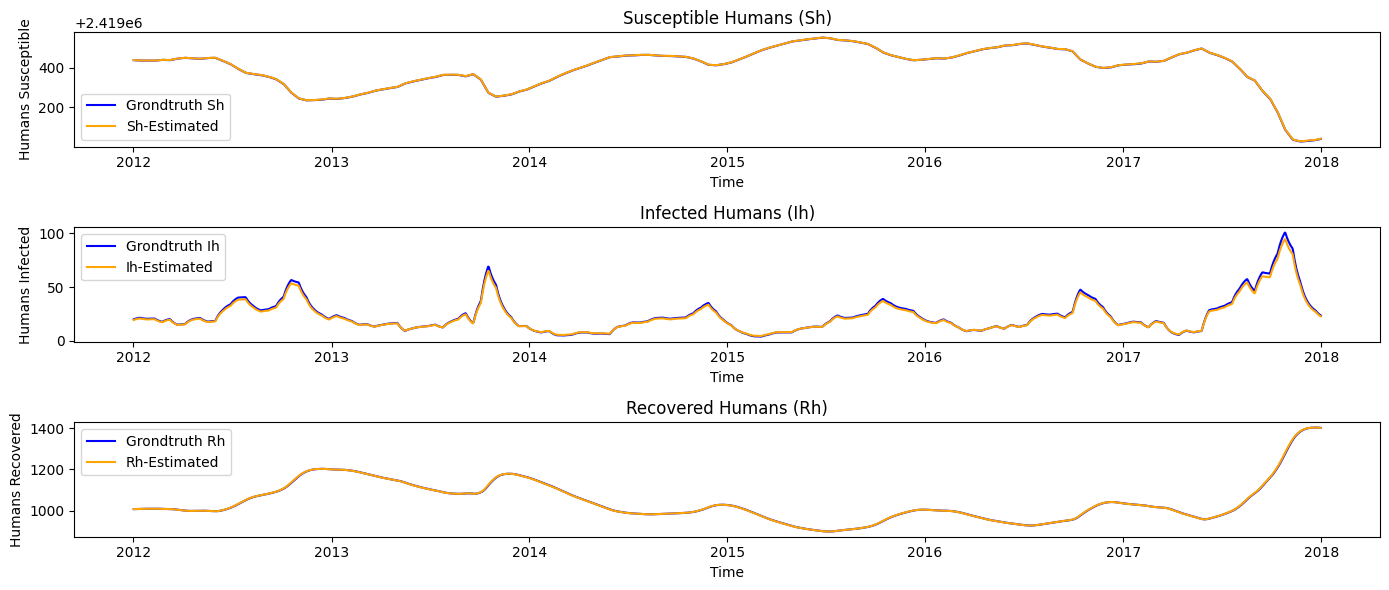

In [94]:

plt.figure(figsize=(14, 6))

# Plot for Sh (Human Susceptible)
plt.subplot(3, 1, 1)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sh[:train_size], label='Grondtruth Sh', color='blue')#color='#a0b9e0')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Sh_pred, label='Sh-Estimated', color='orange')#color='#eba58d')
plt.title('Susceptible Humans (Sh)')
plt.xlabel('Time')
plt.ylabel('Humans Susceptible')
plt.legend()

# Plot for Ih (Human Infected)
plt.subplot(3, 1, 2)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ih[:train_size], label='Grondtruth Ih', color='blue')#color='#a0b9e0')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Ih_pred, label='Ih-Estimated', color='orange')#color='#eba58d')
plt.title('Infected Humans (Ih)')
plt.xlabel('Time')
plt.ylabel('Humans Infected')
plt.legend()

# Plot for Rh (Human Recovered)
plt.subplot(3, 1, 3)
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Rh[:train_size], label='Grondtruth Rh', color='blue')
plt.plot(data_covariates['Date'][sequence_length:][:train_size], Rh_pred, label='Rh-Estimated', color='orange')
plt.title('Recovered Humans (Rh)')
plt.xlabel('Time')
plt.ylabel('Humans Recovered')
plt.legend()

plt.tight_layout()
# Save the figure as a PNG file
#plt.savefig("../results/predictions_plot_1stmodel_floodTEMPcases_seqlen1_onlyhumans.png", dpi=300)  # Save with high resolution
plt.show()


# PLOTTING PREDICTED VALUES OF PARAMETERS (BetaHL)

In [95]:

# Set the models to evaluation mode
#betaHL_model.eval()

# Disable gradient calculation
with torch.no_grad():  
    # Get the predicted values for betaHL and betaAL
    betaHL_values = betaHL_model(combined_features_Ih)

# Plotting the predicted values
time_steps = range(len(Sh_z))  # Assuming Sh_data and Sa_data have the same length


In [96]:
#betaHL_list = np.array(betaHL_list)
combined_betaHL_est_np = betaHL_values.detach().numpy().flatten()

#combined_betaHL_est_np = np.concatenate([outputs_betaHL_train_np, outputs_betaHL_test_np])

combined_betaHL_est_scaled = (combined_betaHL_est_np - combined_betaHL_est_np.min()) / (combined_betaHL_est_np.max() - combined_betaHL_est_np.min())
combined_betaHL_est_scaled = combined_betaHL_est_scaled * (betaHL_list.max() - betaHL_list.min()) + betaHL_list.min()

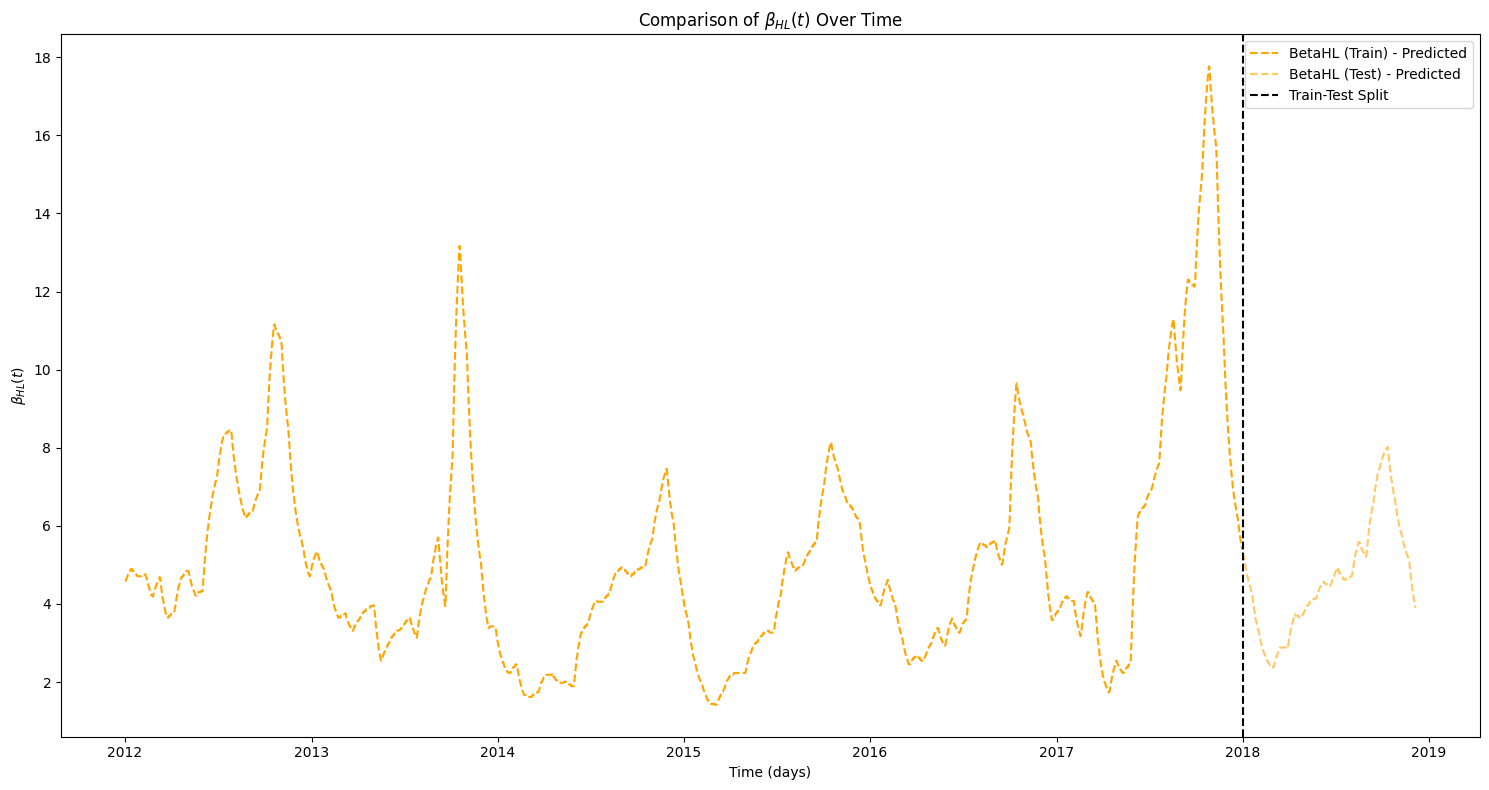

In [97]:


x_axis = data_covariates['Date'][sequence_length:]

plt.figure(figsize=(15, 8))

plt.plot(x_axis[:train_size], combined_betaHL_est_scaled[:train_size], 
         label="BetaHL (Train) - Predicted", 
         color='orange', linestyle='--')

# Plot BetaHL testing
plt.plot(x_axis[train_size:], combined_betaHL_est_scaled[train_size:], 
         label="BetaHL (Test) - Predicted", 
         color='orange', linestyle='--', alpha=0.6)

# Mark the train-test split
plt.axvline(x=x_axis.iloc[train_size], color="k", linestyle="--", label="Train-Test Split")

plt.title(r"Comparison of $\beta_{HL}(t)$ Over Time")
plt.xlabel("Time (days)")
plt.ylabel(r"$\beta_{HL}(t)$")
plt.legend()
plt.tight_layout()
plt.show()


In [98]:
# Split predictions into training and testing
betaHL_train = combined_betaHL_est_scaled[:train_size]
betaHL_test = combined_betaHL_est_scaled[train_size:]

# Corresponding dates
dates_all = data_covariates['Date'][sequence_length:].values
dates_train = dates_all[:train_size]
dates_test = dates_all[train_size:]

# Create DataFrames
df_betaHL_train = pd.DataFrame({
    'Date': dates_train,
    'Scaled_BetaHL_Pred': betaHL_train
})

df_betaHL_test = pd.DataFrame({
    'Date': dates_test,
    'Scaled_BetaHL_Pred': betaHL_test
})

# Save to CSV
#df_betaHL_train.to_csv("../results/predicted_betaHL_1stmodel_floodTEMPcases_train.csv", index=False)
#df_betaHL_test.to_csv("../results/predicted_betaHL_1stmodel_floodTEMPcases_test.csv", index=False)


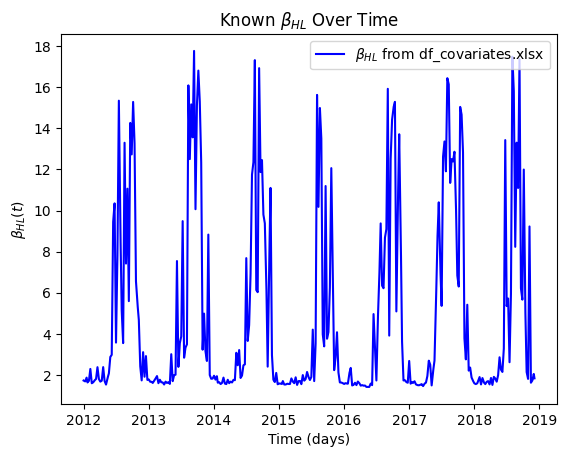

In [99]:
betaHL_list = []
betaAL_list = []
#save water_index, and temp
WaterIndex_list = []
Temperature_list = []
for t in range(len(data)):
    betaHA, betaAA, betaHL, betaAL, omega, m, t1, t2, K, Nh, Na = params
    ID = [61, 67, 4, 30, 16, 13, 77]  # One less than R because Python is zero-indexed
    i = 6  # This is the equivalent of the 7th element in R, which is 78, but in Python it's 77
    tx1 = t + 365
    tau = 7 * t1
    twi = tx1 - tau
    mndwi_days = MNDWI['Day'].values
    mndwi_values = MNDWI.iloc[:, ID[i] + 3].values  # column index is ID[i] + 3, which equals 81 in Python
    # Assuming there are no negative values expected, we use max to ensure non-negative WI2
    WI2 = max(0, np.interp(twi, mndwi_days, mndwi_values))
    WaterIndex_list.append(WI2)

    tau2 = t2 * 7
    tte = tx1 - tau2
    temp_days = Temp['Day'].values
    temp_values = Temp.iloc[:, ID[i] + 3].values  # column index is ID[i] + 3, which equals 81 in Python
    # Assuming there are no negative values expected, we use max to ensure non-negative Tp2
    Tp2 = max(0, np.interp(tte, temp_days, temp_values))
    Temperature_list.append(Tp2)
    # Update betaHL and betaAL
    h_1, h_2, h_3 = 1.503251007, 10.87707487, -0.094485304
    a_1, a_2, a_3 = 0.908905803, 0.467954396, -0.195424336
    betaHL = h_1*(1+h_2*WI2+h_3*Tp2)
    betaAL = a_1*(1+a_2*WI2-a_3*Tp2)
    betaHL_list.append(betaHL)
    betaAL_list.append(betaAL)
    
#plt.plot(betaHL_list, label='betaHL', color='red')
plt.plot(df_covariates['Date'][start_Day:end_Day].values, df_covariates["betaHL"][start_Day:end_Day].values, label=r'$\beta_{HL}$ from df_covariates.xlsx', color='blue')
plt.xlabel('Time (days)')
plt.ylabel(r'$\beta_{HL}(t)$')
plt.title(r'Known $\beta_{HL}$ Over Time')
plt.legend()
plt.show()



In [100]:
# Create a DataFrame from the two time-series
time_series_data = pd.DataFrame({
    'Date': data_covariates['Date'][sequence_length:].values,
    'Scaled_BetaHL_Pred': combined_betaHL_est_scaled
})

# Save the DataFrame to a CSV file
#time_series_data.to_csv("../results/predicted_betaHL_1stmodel_floodTEMPcases_seqlen1_estimate.csv", index=False)



In [101]:

betaAL_list = df_covariates["betaAL"].values
n = len(betaAL_list)-sequence_length
days_array = np.arange(start_Day, end_Day, 1)[:n]
betaAL_list = betaAL_list[:n]

params are [2.14e-06, 8.094831721, 9.886471, 0.04308573, 1.376906477, 0.1644052, 3.0, 11.0, 1696400, 2420465.0, 829574.000000002]


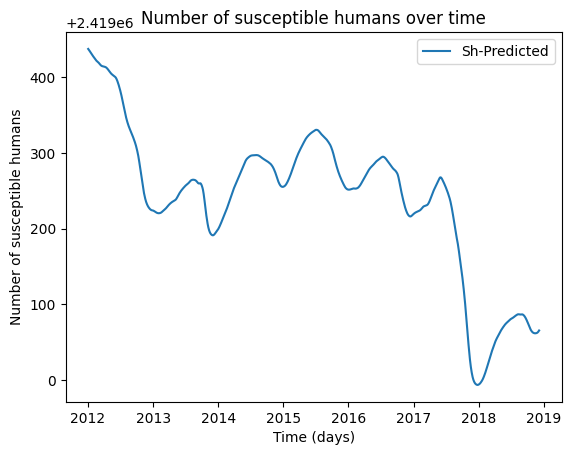

In [102]:


from scipy.integrate import odeint
# Define the ODE system
def model_ode(y, t, params, i):
    Sh, Ih, Rh, Sa, Ia, Ra, L, Ch = y
    betaHA, betaAA, _, _, omega, m, t1, t2, K, Nh, Na = params

    muH=1.0/(70*365); gammaH=1.0/14; nuH=1.0/720
    muA=1.0/(3*365); gammaA=1.0/200; nuA=1.0/540
    muL=0.02381;  chi=100000 #chi=1e5
    # For ID list, following Python's zero-based indexing
    ID = [61, 67, 4, 30, 16, 13, 77]  # One less than R because Python is zero-indexed
    #ID = [62,68,5,31,17,14,78] #R
    # Set i to the Python index equivalent of R's `i=7`
    # actually, we can set this value for all including ID and initial conds like pop!!
    i = 6  # This is the equivalent of the 7th element in R, which is 78, but in Python it's 77

    betaHL = np.interp(t, days_array, combined_betaHL_est_scaled)
    betaAL = np.interp(t, days_array, betaAL_list)
    #betaHL = h_1*(1+h_2*WI2+h_3*Tp2)
    #betaAL = a_1*(1+a_2*WI2-a_3*Tp2) 

    # ODE equations
    dSh = muH*Nh-betaHA * Ia * Sh / Nh - betaHL * (L / (L + K)) * Sh / Nh  - muH*Sh + nuH*Rh
    dIh = betaHA * Ia * Sh / Nh + betaHL * (L / (L + K)) * Sh / Nh - gammaH*Ih - muH*Ih
    dRh = gammaH*Ih - muH*Rh - nuH*Rh
    dSa = muA*Na-betaAA*Ia*Sa/Na - betaAL*(L/(L+K))*Sa/Na  - muA*Sa + nuA*Ra #sa
    dIa = betaAA * Ia * Sa / Na + betaAL * (L / (L + K)) * Sa / Na - gammaA*Ia - muA*Ia
    dRa = gammaA*Ia - nuA*Ra - muA*Ra
    dL = omega * Ia + m * ((chi - L) / chi) * L - muL * L
    dCh = betaHA * Ia * Sh / Nh + betaHL * (L / (L + K)) * Sh / Nh

    return [dSh, dIh, dRh, dSa, dIa, dRa, dL, dCh]


print('params are', params)

times = np.arange(0, len(combined_betaHL_est_scaled), 1)

# Solve the ODEs
pred_results = odeint(model_ode, initial_conditions, times, args=(params, 0))

plt.plot(data_covariates['Date'][sequence_length:], pred_results[:, 0], label='Sh-Predicted')
plt.xlabel('Time (days)')
plt.ylabel('Number of susceptible humans')
plt.title('Number of susceptible humans over time')
plt.legend()  # Add this line to display the legend
# Show the plot
plt.show()

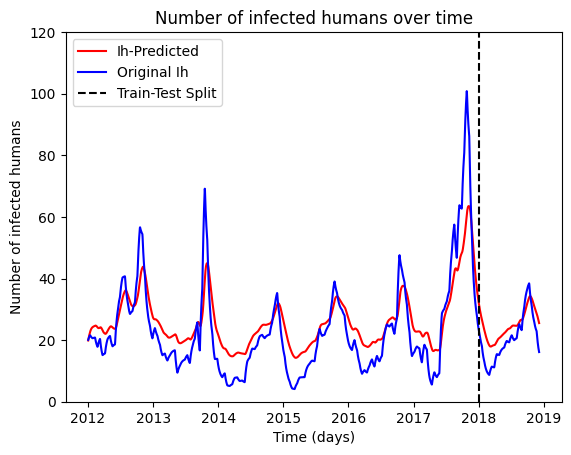

In [103]:
plt.plot(data_covariates['Date'][sequence_length:], pred_results[:, 1], label='Ih-Predicted', color='red')
plt.plot(data_covariates['Date'][sequence_length:], Ih[:len(combined_betaHL_est_scaled)], label='Original Ih', color='blue')
# Mark the train-test split
plt.axvline(x=x_axis.iloc[train_size], color="k", linestyle="--", label="Train-Test Split")
plt.ylim(0, 120)
plt.xlabel('Time (days)')
plt.ylabel('Number of infected humans')
plt.title('Number of infected humans over time')
plt.legend()  # Add this line to display the legend
# Show the plot
plt.show()

In [104]:
#new
# Define true and predicted values
y_true = Ih[:len(Ih)]  # True infected cases
y_pred_lstm = pred_results[:, 1][:len(Ih)]  # Predicted infected cases (LSTM)

# Compute Metrics
mse = np.mean((y_true - y_pred_lstm)**2)  # Mean Squared Error
mae = np.mean(np.abs(y_true - y_pred_lstm))  # Mean Absolute Error
mape = np.mean(np.abs((y_true - y_pred_lstm) / y_true)) * 100  # Mean Absolute Percentage Error
smape = np.mean(2 * np.abs(y_true - y_pred_lstm) / (np.abs(y_true) + np.abs(y_pred_lstm)) * 100)  # SMAPE
rmse = np.sqrt(mse)  # Root Mean Square Error
nrmse = rmse / (np.max(y_true) - np.min(y_true))  # Normalized RMSE
rel = np.mean(np.abs((y_true - y_pred_lstm) / y_true)) * 100  # Relative Error

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Normalized Root Mean Square Error (NRMSE): {nrmse:.4f}")
print(f"Relative Error (REL): {rel:.4f}%")


Mean Squared Error (MSE): 65.7421
Mean Absolute Error (MAE): 6.5428
Mean Absolute Percentage Error (MAPE): 43.3488%
Symmetric Mean Absolute Percentage Error (SMAPE): 32.0279%
Root Mean Square Error (RMSE): 8.1082
Normalized Root Mean Square Error (NRMSE): 0.0838
Relative Error (REL): 43.3488%


In [105]:

compartment_names = [
    "Sh_pred",
    "Ih_pred",
    "Rh_pred",
    "Sa_pred",
    "Ia_pred",
    "Ra_pred",
    "L_pred",
    "Ch_pred"
]

# Convert pred_results to a DataFrame and name the columns
df_pred = pd.DataFrame(pred_results[:, 0:8], columns=compartment_names)

# Add Date column from the sliced data
df_pred["Date"] = data_covariates['Date'][sequence_length:].values

# Reorder columns so Date is first (if desired)
df_pred = df_pred[["Date"] + compartment_names]

# Save to Excel
output_filename = "../results/predictions_plot_1stmodel_floodTEMPcases_seqlen1_oneinitcond.xlsx"
#df_pred.to_excel(output_filename, index=False)

print(f"Data successfully exported to '{output_filename}'.")


Data successfully exported to '../results/predictions_plot_1stmodel_floodTEMPcases_seqlen1_oneinitcond.xlsx'.


In [106]:
# Split df_pred into training and testing
df_pred_train = df_pred.iloc[:train_size].copy()
df_pred_test  = df_pred.iloc[train_size:].copy()

# Save to Excel (or CSV if you prefer)
#df_pred_train.to_excel("../results/predictions_plot_1stmodel_floodTEMPcases_seqlen1_oneinitcond_train.xlsx", index=False)
#df_pred_test.to_excel("../results/predictions_plot_1stmodel_floodTEMPcases_seqlen1_oneinitcond_test.xlsx", index=False)

print("All training and testing outputs saved successfully.")


All training and testing outputs saved successfully.
